In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from helper_functions import plot_images_side_by_side,make_paired_dataset
from model import get_cnn_block

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [2]:

img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_A_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 img_B_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   1586496   ['img_A_inp[0][0]',           
                                                                     'img_B_inp[0][0]']           
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential_4[0][0]',    

2025-03-16 18:26:59.138249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-16 18:26:59.138453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:

random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [ ]:
make_paired_dataset(X_train_sample, y_train_sample)


In [5]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [6]:
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [7]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [9]:

es = EarlyStopping(patience=3)

In [14]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=1000,
          batch_size=32,
          callbacks=[es])

Epoch 1/1000
2813/2813 [==============================] - 533s 190ms/step - loss: 0.1247 - accuracy: 0.9515 - val_loss: 0.2288 - val_accuracy: 0.9344
Epoch 2/1000
2813/2813 [==============================] - 533s 190ms/step - loss: 0.0194 - accuracy: 0.9931 - val_loss: 0.2014 - val_accuracy: 0.9404
Epoch 3/1000
2813/2813 [==============================] - 533s 190ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.2026 - val_accuracy: 0.9597
Epoch 4/1000
2813/2813 [==============================] - 533s 190ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.1558 - val_accuracy: 0.9653
Epoch 5/1000
2813/2813 [==============================] - 533s 190ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.3842 - val_accuracy: 0.9124
Epoch 6/1000
2813/2813 [==============================] - 534s 190ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.1577 - val_accuracy: 0.9660
Epoch 7/1000
2813/2813 [==============================] - 532s 189ms/step - loss: 0.0031 - accuracy:

In [ ]:

model.save('siamese_model.h5')

model.save_weights('siamese_weights.h5')

/home/sai/SiameseNet/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


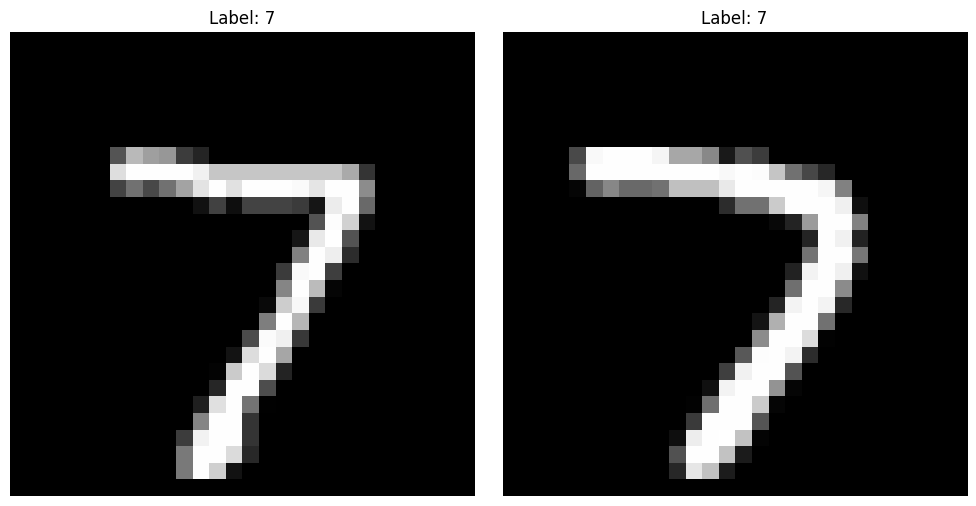

In [10]:
img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

plot_images_side_by_side(img_A, img_B,label_A, label_B)


In [17]:
model.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5

1/1 [==============================] - 0s 109ms/step


True

In [ ]:
img_a, img_b = X_test[0], X_test[15]
label_A, label_B = y_test[0], y_test[15]

label_A, label_B

plot_images_side_by_side(img_a, img_b,label_A, label_B)

(7, 5)

In [26]:
model.predict([img_a.reshape((1, 28, 28)),
               img_b.reshape((1, 28, 28))]).flatten()[0] > 0.5

1/1 [==============================] - 0s 18ms/step


False